In [0]:
# Code block for imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
# ------------------Importing the Dataset-------------------

# URLs to the dataset files. Do NOT edit these variables.

baseline_url = 'https://raw.githubusercontent.com/shbhmsxn4/BCI-EEG-Dataset-Partial/master/Baseline.csv'
right_forward_url = 'https://raw.githubusercontent.com/shbhmsxn4/BCI-EEG-Dataset-Partial/master/RightForwardImagined.csv'
right_backward_url = 'https://raw.githubusercontent.com/shbhmsxn4/BCI-EEG-Dataset-Partial/master/RightBackwardImagined.csv'
left_forward_url = 'https://raw.githubusercontent.com/shbhmsxn4/BCI-EEG-Dataset-Partial/master/LeftForwardImagined.csv'
left_backward_url = 'https://raw.githubusercontent.com/shbhmsxn4/BCI-EEG-Dataset-Partial/master/LeftBackwardImagined.csv'

# Dataframe variables storing the respective datasets.

df_baseline = pd.read_csv(baseline_url, header=None)
df_baseline = df_baseline.iloc[:,:7000]

df_right_forward = pd.read_csv(right_forward_url, header=None)
df_right_forward = df_right_forward.transpose()
df_right_forward = df_right_forward.iloc[:,:7000]

df_right_backward = pd.read_csv(right_backward_url, header=None)
df_right_backward = df_right_backward.transpose()
df_right_backward = df_right_backward.iloc[:,:7000]

df_left_forward = pd.read_csv(left_forward_url, header=None)
df_left_forward = df_left_forward.transpose()
df_left_forward = df_left_forward.iloc[:,:7000]

df_left_backward = pd.read_csv(left_backward_url, header=None)
df_left_backward = df_left_backward.transpose()
df_left_backward = df_left_backward.iloc[:,:7000]


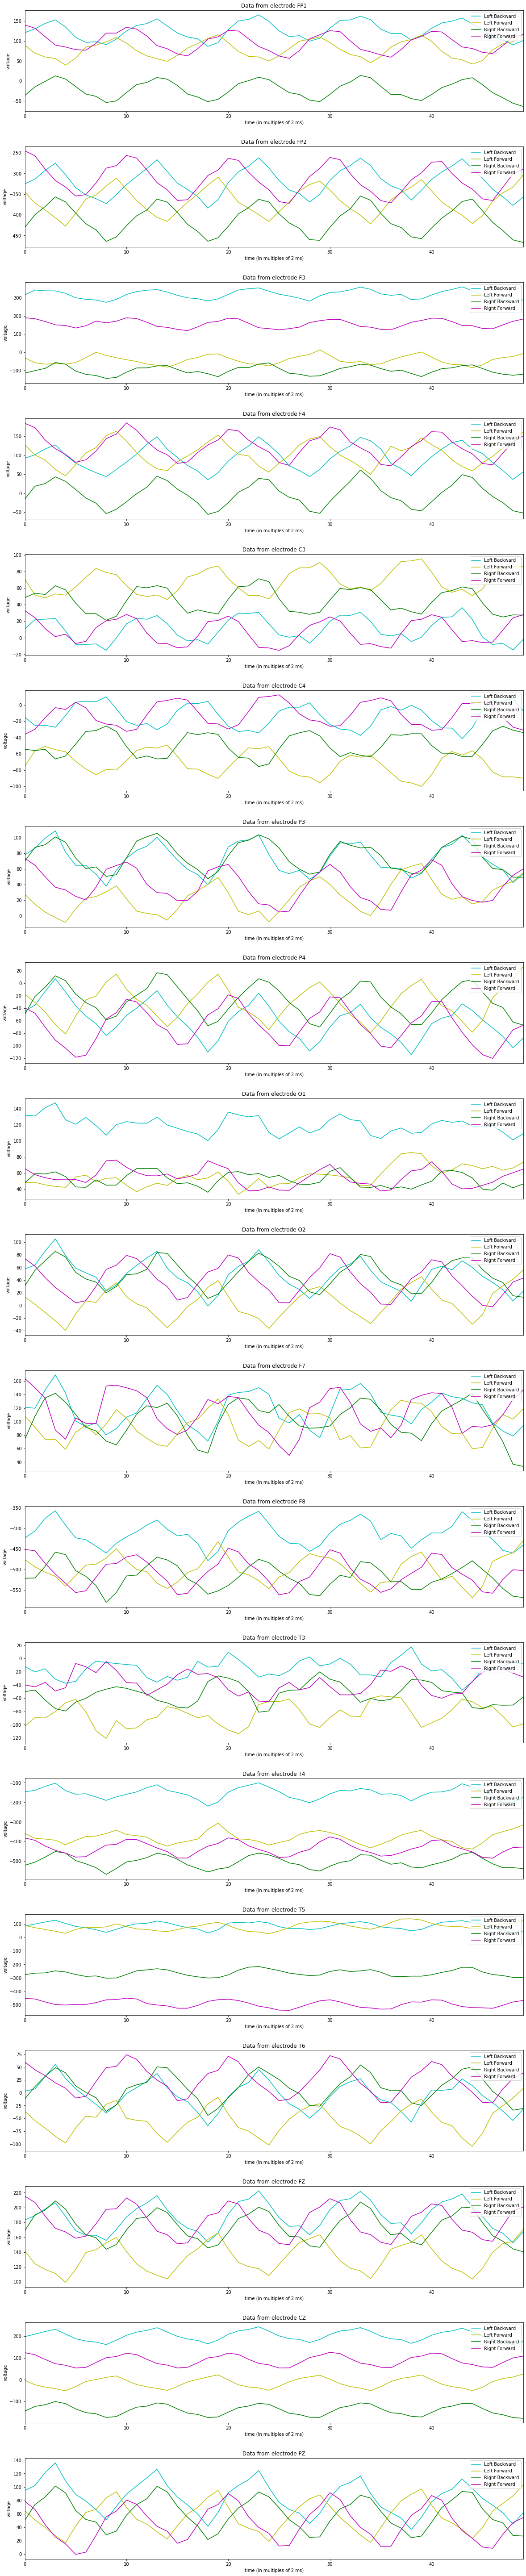

In [0]:
# -----------------------------Visualising the Data--------------------------------
# This code displays a single trial of data, with all channels in different subplots
# Note: Optional to run

df_list = [df_left_backward, df_left_forward, df_right_backward, df_right_forward]
color_list = ['c', 'y', 'g', 'm']
electrode_list = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']

plt.subplots_adjust(hspace=0.35)

for i in range(0, 19):
  plt.subplot(19, 1, i+1)
  for idx, df in enumerate(df_list):
    df.iloc[i, :50].plot(figsize=(20, 5*21), color=color_list[idx])
  plt.xlabel('time (in multiples of 2 ms)')
  plt.ylabel('voltage')
  plt.title('Data from electrode ' + electrode_list[i])
  plt.legend(['Left Backward', 'Left Forward', 'Right Backward', 'Right Forward'], loc='upper right')


In [0]:
# --------------------Compiling the Data--------------------------

np.split(df_baseline, 140, 1)

right_forward_trials = np.dstack(np.split(df_right_forward, 140, 1)).transpose(2, 0, 1)
right_backward_trials = np.dstack(np.split(df_right_backward, 140, 1)).transpose(2, 0, 1)
left_forward_trials = np.dstack(np.split(df_left_forward, 140, 1)).transpose(2, 0, 1)
left_backward_trials = np.dstack(np.split(df_left_backward, 140, 1)).transpose(2, 0, 1)

left_backward_targets = np.array(['Left Backward'] * 140)
left_forward_targets = np.array(['Left Forward'] * 140)
right_backward_targets = np.array(['Right Backward'] * 140)
right_forward_targets = np.array(['Right Forward'] * 140)

X = np.concatenate((left_backward_trials, left_forward_trials, right_backward_trials, right_forward_trials))
y = np.concatenate((left_backward_targets, left_forward_targets, right_backward_targets, right_forward_targets))



In [0]:
# ---------------------Scaling the Data-------------------------
# Normalizes each channel into z-scores

scalers = {}

for i in range(X.shape[1]):
  scalers[i] = StandardScaler()
  X[:, i, :] = scalers[i].fit_transform(X[:, i, :])

In [0]:
# -------------------Label Encoding------------------------------

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)

y = label_encoder.fit_transform(y)
y = y.reshape(len(y), 1)
y = one_hot_encoder.fit_transform(y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
# ------------------Splitting Data-----------------------------

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.46428)
X_train, X_validate, y_train, y_validate = train_test_split(X_tv, y_tv, test_size=0.3333)

X_train = np.expand_dims(X_train, axis=2)
X_validate = np.expand_dims(X_validate, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [0]:
# ---------------Preprocessing Completed----------------------

# Training dataset: X_train, y_train
# Validation dataset: X_validate, y_validate
# Test dataset: X_test, y_test

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Softmax, Activation
from keras.activations import softmax
from keras import backend as K
from keras.utils import to_categorical
from keras import optimizers
from keras.initializers import he_uniform
import keras

Using TensorFlow backend.


In [0]:
# ------------------Loggers & Optimizer--------------------------

class DataLogger(keras.callbacks.Callback):
    def __init__(self, acc_list, X_val, y_val):
      self.acc_list = acc_list
      self.X_val = X_val
      self.y_val = y_val
      self.seen = 0
    
    def on_batch_end(self, batch, logs={}):
      self.seen += 1
      loss, acc = self.model.evaluate(self.X_val, self.y_val, verbose = 0)
      self.acc_list.append(acc)
      if self.seen % 10  == 0:
        print('Batch {} - accuracy: {}'.format(self.seen, acc))


w_init = 'he_uniform'
sgd = 'sgd'

num_epochs = 2


In [0]:
K.set_image_data_format('channels_first')

msd_inputs = Input(batch_shape=(5, 19, 1, 50), dtype='float32') 

msd_conv_layer1 = Conv2D(
      filters=20,
      kernel_size=(1, 3),
      activation='tanh',
      use_bias=True,
      kernel_initializer=w_init,
      bias_initializer='zeros'
)(msd_inputs)

msd_pool_layer1 = MaxPooling2D(
    pool_size=(1, 2),
    strides=None
)(msd_conv_layer1)

msd_conv_layer2 = Conv2D(
    filters=40,
    kernel_size=(1, 3),
    activation='relu',
    use_bias=True
)(msd_pool_layer1)

msd_pool_layer2 = MaxPooling2D(
    pool_size=(1, 2),
    strides=None
)(msd_conv_layer2)

msd_conv_layer3 = Conv2D(
    filters=60,
    kernel_size=(1, 3),
    activation='tanh',
    use_bias=True,
    kernel_initializer=w_init,
    bias_initializer='zeros'
)(msd_pool_layer2)

msd_pool_layer3 = MaxPooling2D(
    pool_size=(1, 3),
    strides=None
)(msd_conv_layer3)

msd_conv_layer4 = Conv2D(
    filters=80,
    kernel_size=(1, 3),
    activation='relu',
    use_bias=True
)(msd_pool_layer3)

msd_flatten_pool_layer3 = Flatten()(msd_pool_layer3)
msd_flatten_conv_layer4 = Flatten()(msd_conv_layer4)

msd_deep_mf_input = concatenate(inputs=[msd_flatten_pool_layer3, msd_flatten_conv_layer4])

msd_deep_mf_layer = Dense(
    units=100,
    activation='relu',
    use_bias=True
)(msd_deep_mf_input)

msd_output_no_softmax = Dense(
    units=4,
    use_bias=True
)(msd_deep_mf_layer)

msd_output = Activation('softmax')(msd_output_no_softmax)

msd_model = Model(inputs=msd_inputs, outputs=msd_output)

# msd_model.summary()

msd_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
msd_acc_list = []
msd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=5, verbose = 2, validation_data=(X_validate, y_validate), callbacks=[DataLogger(msd_acc_list, X_validate, y_validate)])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 200 samples, validate on 100 samples
Epoch 1/2
Batch 10 - accuracy: 0.62
Batch 20 - accuracy: 0.89
Batch 30 - accuracy: 0.99
Batch 40 - accuracy: 1.0
 - 1s - loss: 0.8397 - acc: 0.7800 - val_loss: 0.3842 - val_acc: 1.0000
Epoch 2/2
Batch 50 - accuracy: 1.0
Batch 60 - accuracy: 1.0
Batch 70 - accuracy: 1.0
Batch 80 - accuracy: 1.0
 - 1s - loss: 0.2445 - acc: 0.9800 - val_loss: 0.1548 - val_acc: 1.0000


In [0]:
msd_score = msd_model.evaluate(X_test, y_test)
print(msd_score)

260/260 [==============================] - 0s 119us/step
[0.16315319813214815, 0.9961538461538462]


In [0]:
K.set_image_data_format('channels_first')

ssd_inputs = Input(batch_shape=(5, 19, 1, 50), dtype='float32')

ssd_conv_layer1 = Conv2D(
      filters=20,
      kernel_size=(1, 3),
      activation='tanh',
      use_bias=True,
      kernel_initializer=w_init,
      bias_initializer='zeros'
)(ssd_inputs)

ssd_pool_layer1 = MaxPooling2D(
    pool_size=(1, 2),
    strides=None
)(ssd_conv_layer1)

ssd_conv_layer2 = Conv2D(
    filters=40,
    kernel_size=(1, 3),
    activation='relu',
    use_bias=True
)(ssd_pool_layer1)

ssd_pool_layer2 = MaxPooling2D(
    pool_size=(1, 2),
    strides=None
)(ssd_conv_layer2)

ssd_conv_layer3 = Conv2D(
    filters=60,
    kernel_size=(1, 3),
    activation='tanh',
    use_bias=True,
    kernel_initializer=w_init,
    bias_initializer='zeros'
)(ssd_pool_layer2)

ssd_pool_layer3 = MaxPooling2D(
    pool_size=(1, 3),
    strides=None
)(ssd_conv_layer3)

ssd_flatten_pool_layer3 = Flatten()(ssd_pool_layer3)

ssd_hidden_input = ssd_flatten_pool_layer3

ssd_hidden = Dense(
    units=100,
    activation='relu',
    use_bias=True
)(ssd_hidden_input)

ssd_output_no_softmax = Dense(
    units=4,
    use_bias=True
)(ssd_hidden)

ssd_output = Activation('softmax')(ssd_output_no_softmax)

ssd_model = Model(inputs=ssd_inputs, outputs=ssd_output)

# ssd_model.summary()

ssd_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
ssd_acc_list = []
ssd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=5, validation_data=(X_validate, y_validate), verbose=2, callbacks=[DataLogger(ssd_acc_list, X_validate, y_validate)])

Train on 200 samples, validate on 100 samples
Epoch 1/2
Batch 10 - accuracy: 0.78
Batch 20 - accuracy: 0.91
Batch 30 - accuracy: 0.95
Batch 40 - accuracy: 0.93
 - 1s - loss: 0.7980 - acc: 0.8400 - val_loss: 0.4091 - val_acc: 0.9300
Epoch 2/2
Batch 50 - accuracy: 0.96
Batch 60 - accuracy: 0.96
Batch 70 - accuracy: 0.97
Batch 80 - accuracy: 0.94
 - 1s - loss: 0.2723 - acc: 0.9700 - val_loss: 0.1980 - val_acc: 0.9400


In [0]:
ssd_score = ssd_model.evaluate(X_test, y_test)
print(ssd_score)

260/260 [==============================] - 0s 114us/step
[0.19141195324751048, 0.9653846153846154]


In [0]:
K.set_image_data_format('channels_first')

sh_inputs = Input(batch_shape=(5, 19, 1, 50), dtype='float32')

sh_conv_layer1 = Conv2D(
      filters=20,
      kernel_size=(1, 3),
      activation='tanh',
      use_bias=True,
      kernel_initializer=w_init,
      bias_initializer='zeros'
)(sh_inputs)

sh_pool_layer1 = MaxPooling2D(
    pool_size=(1, 2),
    strides=None
)(sh_conv_layer1)

sh_conv_layer2 = Conv2D(
    filters=40,
    kernel_size=(1, 3),
    activation='relu',
    use_bias=True
)(sh_pool_layer1)

sh_pool_layer2 = MaxPooling2D(
    pool_size=(1, 2),
    strides=None
)(sh_conv_layer2)

sh_flatten_pool_layer2 = Flatten()(sh_pool_layer2)

sh_hidden_input = sh_flatten_pool_layer2

sh_hidden = Dense(
    units=100,
    activation='relu',
    use_bias=True
)(sh_hidden_input)

sh_output_no_softmax = Dense(
    units=4,
    use_bias=True
)(sh_hidden)

sh_output = Activation('softmax')(sh_output_no_softmax)

sh_model = Model(inputs=sh_inputs, outputs=sh_output)

# sh_model.summary()

sh_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
sh_acc_list = []
sh_model.fit(X_train, y_train, epochs=num_epochs, batch_size=5, validation_data=(X_validate, y_validate), verbose=2, callbacks=[DataLogger(sh_acc_list, X_validate, y_validate)])

Train on 200 samples, validate on 100 samples
Epoch 1/2
Batch 10 - accuracy: 0.69
Batch 20 - accuracy: 0.9
Batch 30 - accuracy: 0.93
Batch 40 - accuracy: 0.97
 - 1s - loss: 0.7872 - acc: 0.7500 - val_loss: 0.3799 - val_acc: 0.9700
Epoch 2/2
Batch 50 - accuracy: 0.97
Batch 60 - accuracy: 0.96
Batch 70 - accuracy: 0.97
Batch 80 - accuracy: 0.98
 - 1s - loss: 0.2260 - acc: 0.9700 - val_loss: 0.1738 - val_acc: 0.9800


In [0]:
sh_score = sh_model.evaluate(X_test, y_test)
print(sh_score)

260/260 [==============================] - 0s 98us/step
[0.1845245287968562, 0.9692307692307692]


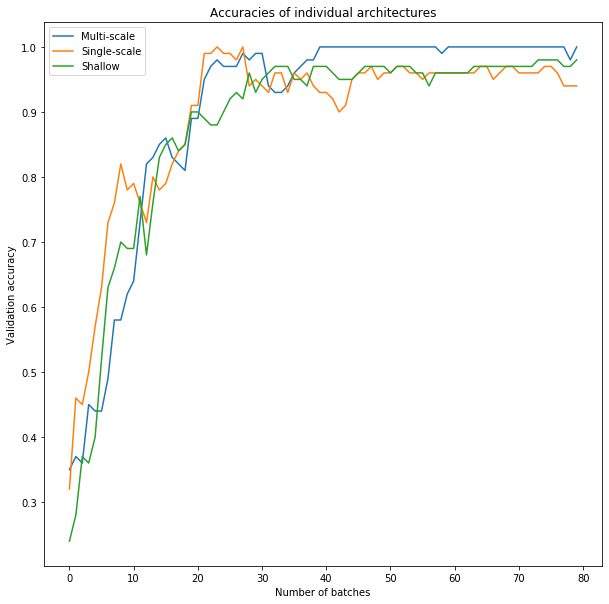

In [0]:
plt.figure(figsize=(10,10))
plt.plot(msd_acc_list)
plt.plot(ssd_acc_list)
plt.plot(sh_acc_list)
plt.title('Accuracies of individual architectures')
plt.xlabel('Number of batches')
plt.ylabel('Validation accuracy')
plt.legend(['Multi-scale', 'Single-scale', 'Shallow'])

In [0]:
print("Multi-scale score: {}".format(msd_score))
print("Single-scale score: {}".format(ssd_score))
print("Shallow score: {}".format(sh_score))

Multi-scale score: [0.16315319813214815, 0.9961538461538462]
Single-scale score: [0.19141195324751048, 0.9653846153846154]
Shallow score: [0.1845245287968562, 0.9692307692307692]
